In [49]:
import matplotlib.pyplot as plt
import json
import random
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np


from scipy.interpolate import UnivariateSpline


121 datapoints
15.904756679999991


[array([12.65473637,  0.37343305]), array([46.30600708, 91.53426626])]

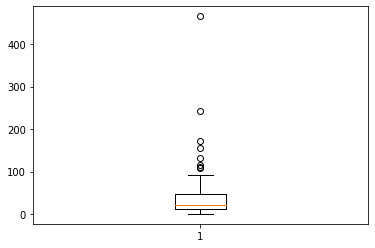

In [63]:
## Avereage movements

def makePairsOfLowPrices(obj):
    return (obj["date"], obj["low"])

def makePairsOfHighPrices(obj):
    return (obj["date"], obj["high"])

def makePairsOfCanldePrices(obj):
    return (obj["date"], obj["high"]-obj["low"])

prices_low = []
prices_high = []
candleLengths = []

with open("res.txt", "r") as fd:
    prices = json.loads(fd.read())
    print(str(len(prices)) + " datapoints")
    prices_low = list(map(makePairsOfLowPrices, prices))
    prices_high = list(map(makePairsOfHighPrices, prices))
    candleLengths = list(map(makePairsOfCanldePrices, prices))

movements = []

for i in range(1, len(prices_low)):
    movements.append(abs(prices_low[i][1] - prices_low[i-1][1]))
print(movements[int(len(movements)/2)])

B = plt.boxplot(movements)
[item.get_ydata() for item in B['whiskers']]


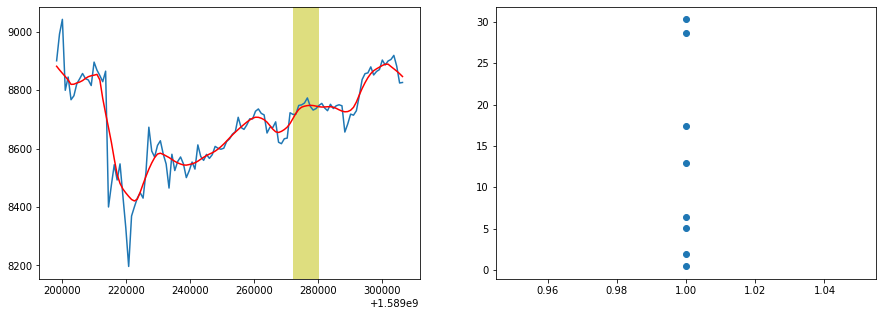

In [14]:
window_size = 10 # Datapoints

bottomIndex = random.randint(0, len(prices_low) - window_size)
topIndex = bottomIndex + 9

x_min = min(list(map(lambda x: x[1], prices_low[bottomIndex: topIndex])))
x_max = max(list(map(lambda x: x[1], prices_low[bottomIndex: topIndex])))

def scale(val):
    return (val-x_min)/(x_max-x_min)

window_y_values = list(map(lambda x: x[1], prices_low[bottomIndex: topIndex]))

delta = []
for i in range(1, len(window_y_values)):
    delta.append(abs(window_y_values[i] - window_y_values[i-1]))

x_prices = list(map((lambda x: x[0]), prices_low))
y_prices = list(map((lambda x: x[1]), prices_low))

lo_1 = lowess(np.array(y_prices), np.array(range(0, len(x_prices))), is_sorted=True, it=3, frac=0.1)
lo_3 = lowess(np.array(y_prices), np.array(range(0, len(x_prices))), is_sorted=True, it=3, frac=0.3)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.axvspan(prices_low[bottomIndex][0], prices_low[topIndex][0], color='y', alpha=0.5, lw=0)
ax1.plot(list(map((lambda x: x[0]), prices_low)), list(map((lambda x: x[1]), prices_low)))
ax1.plot(list(map((lambda x: x[0]), prices_low)), list(map((lambda x: x[1]),lo_1)), color='r')

ax2.scatter([1]*len(delta), delta)

plt.show()

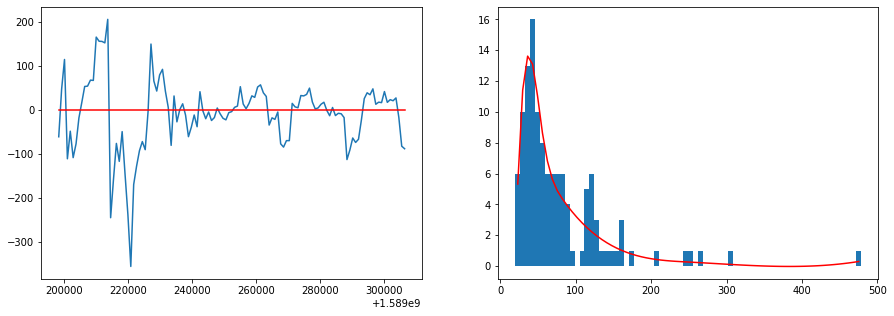

In [65]:
fig2, (ax11, ax22) = plt.subplots(1, 2, figsize=(15,5))

## 1. Divergense from smothed price
noise = []
for i in range(len(y_prices)):
    trend = list(map((lambda x: x[1]), lo_3))[i]
    price = y_prices[i]
    noise.append(price-trend)

ax11.plot(list(map((lambda x: x[0]), prices_low)), noise)
ax11.plot(list(map((lambda x: x[0]), prices_low)), [0]*len(noise), color='r')

## Probability density function of candle heights
nr_of_bins = 70
p, x = np.histogram(list(map(lambda x: x[1], candleLengths)), bins=nr_of_bins) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=nr_of_bins)

ax22.plot(x, f(x),c="r")

a = ax22.hist(list(map(lambda x: x[1], candleLengths)), bins=nr_of_bins) ## x = list(map(lambda x: x[0], candleLengths))
sum_events = sum(a[0])

probDist = list(map(lambda x: x/sum_events, a[0]))

